# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import glob
from math import radians, cos, sin, asin, sqrt

# Import csv files

In [2]:
# Removed files with 0mb and also 2019. We want to know 2020-10 tm 2020-12 for now.
files = glob.glob(r'GVB/*.csv')
gvb_data = pd.concat( (pd.read_csv(file, sep=";") for file in files), ignore_index = True)
gvb_data

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
0,10/31/2020 12:00:00 AM,18:00 - 18:59,NaN,Overig,NaN,NaN,1
1,11/30/2020 12:00:00 AM,00:00 - 00:59,NaN,Overig,NaN,NaN,4
2,11/30/2020 12:00:00 AM,01:00 - 01:59,NaN,Overig,NaN,NaN,53
3,11/30/2020 12:00:00 AM,02:00 - 02:59,NaN,Overig,NaN,NaN,49
4,11/30/2020 12:00:00 AM,03:00 - 03:59,NaN,Overig,NaN,NaN,30
...,...,...,...,...,...,...,...
3272642,10/24/2021 12:00:00 AM,23:00 - 23:59,WLP,Waterlooplein,4.902982,52.366979,47
3272643,10/24/2021 12:00:00 AM,23:00 - 23:59,WPP,Weesperplein,4.907875,52.361201,53
3272644,10/24/2021 12:00:00 AM,23:00 - 23:59,WTC,Station Zuid,4.875099,52.339080,213
3272645,10/25/2021 12:00:00 AM,00:00 - 00:59,[[ Onb,[[ Onbekend ]],0.000000,0.000000,189


In [3]:
# Read Resono data for later
resono = pd.read_csv("Resono_all.csv")
resono

,Unnamed: 0,Location,Locationcode,Start,End,Visits,Start_Dates,Start_Time,End_Dates,End_Time
0,204,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T00:00:00+00:00,2020-09-30T00:14:59+00:00,3,2020-09-30,00:00:00,2020-09-30,00:14:59
1,205,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T00:15:00+00:00,2020-09-30T00:29:59+00:00,2,2020-09-30,00:15:00,2020-09-30,00:29:59
2,206,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T00:30:00+00:00,2020-09-30T00:44:59+00:00,2,2020-09-30,00:30:00,2020-09-30,00:44:59
3,207,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T00:45:00+00:00,2020-09-30T00:59:59+00:00,2,2020-09-30,00:45:00,2020-09-30,00:59:59
4,208,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T01:00:00+00:00,2020-09-30T01:14:59+00:00,1,2020-09-30,01:00:00,2020-09-30,01:14:59
...,...,...,...,...,...,...,...,...,...,...
339245,4803707,Vondelpark Oost,581b90d8-cd25-4bd4-9ae7-1b063aed2c29,2021-02-21T23:30:00+00:00,2021-02-21T23:44:59+00:00,708,2021-02-21,23:30:00,2021-02-21,23:44:59
339246,4803709,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,2021-02-21T23:30:00+00:00,2021-02-21T23:44:59+00:00,211,2021-02-21,23:30:00,2021-02-21,23:44:59
339247,4804043,Oosterpark,9aa5b4ac-505e-4da6-977d-edc87469781d,2021-02-21T23:30:00+00:00,2021-02-21T23:44:59+00:00,245,2021-02-21,23:30:00,2021-02-21,23:44:59
339248,4804073,Westergasfabriek,1dd13bd7-2692-43bd-aaff-af55efcf5023,2021-02-21T23:30:00+00:00,2021-02-21T23:44:59+00:00,1,2021-02-21,23:30:00,2021-02-21,23:44:59


# Preprocess GVB data

In [4]:
# Set dates to datetime
# Only select data from 10-2020 till 12-2021
# Drop if destination is unknown
# Remove NaN and [[ Onbekend ]] values
gvb_data['Datum'] = pd.to_datetime(gvb_data['Datum'])
gvb_data = gvb_data.sort_values(by=['Datum', 'UurgroepOmschrijving (van aankomst)'])
gvb_data_range = gvb_data[(gvb_data['Datum'] >= '2020-10-1') & (gvb_data['Datum'] <= '2021-12-31')]
gvb_data_range_cleaned = gvb_data_range[gvb_data_range['AankomstHalteCode'].notnull()]
gvb_data_range_cleaned = gvb_data_range_cleaned[gvb_data_range_cleaned['AankomstHalteNaam'] != "[[ Onbekend ]]"]
gvb_data_range_cleaned.head()

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
244710,2020-10-01,00:00 - 00:59,05022,Centraal Station,4.901043,52.377720,14
244711,2020-10-01,00:00 - 00:59,08247,Vennepluimstraat,4.990572,52.357697,11
244712,2020-10-01,00:00 - 00:59,ASA,Amstelstation,4.917514,52.346473,28
244713,2020-10-01,00:00 - 00:59,ASW,Amstelveenseweg,4.857983,52.338367,12


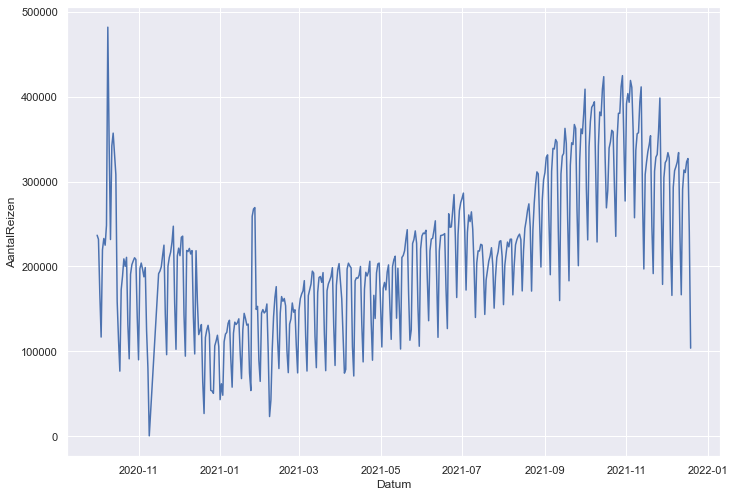

In [5]:
gvb_data_range_cleaned_travellers_per_day = gvb_data_range_cleaned.groupby(['Datum']).sum().reset_index()
gvb_data_range_cleaned_travellers_per_day.head()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Datum", y="AantalReizen", data=gvb_data_range_cleaned_travellers_per_day);

In [6]:
# Strange, there seems to be missing data 2020-11-08, let's check this. 395 is very very low, so let's replace
# this outlier with one week before
gvb_data_range_cleaned_travellers_per_day.set_index('Datum')["2020-11"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,AankomstLat,AankomstLon,AantalReizen
Datum,,,
2020-11-01,12702.356859,136028.470307,89996
2020-11-02,24511.491338,262426.020935,197347
2020-11-03,25084.545785,268550.383348,203996
2020-11-04,24236.090222,259493.620806,196745
2020-11-05,23355.420156,250067.793310,187776
2020-11-06,24050.847712,257500.428780,198735
2020-11-07,16397.032755,175557.136745,124235
2020-11-08,11192.944968,119901.210636,80213
2020-11-09,113.048821,1204.008159,395


In [7]:
# Replace missing data with one week before
gvb_data_range_cleaned_without_9_november = gvb_data_range_cleaned[gvb_data_range_cleaned['Datum'] != "2020-11-09"]
gvb_week46 = gvb_data_range_cleaned[(gvb_data_range_cleaned['Datum'] >= '2020-11-02') & (gvb_data_range_cleaned['Datum'] <= '2020-11-08')]
gvb_week46['Datum'] = gvb_week46["Datum"] + dt.timedelta(days=7)
frames = [gvb_data_range_cleaned_without_9_november, gvb_week46]
gvb_data_range_very_cleaned = pd.concat(frames)
gvb_data_range_very_cleaned.sort_values(by="Datum", inplace=True)

gvb_data_range_very_cleaned                            

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
248507,2020-10-01,16:00 - 16:59,DMZ,Station Diemen-Zuid,4.957133,52.330428,139
248506,2020-10-01,16:00 - 16:59,CS,Centraal Station,4.900781,52.377494,1261
248505,2020-10-01,16:00 - 16:59,CLL,Station Lelylaan,4.834266,52.357663,205
248504,2020-10-01,16:00 - 16:59,BMR,Station Bijlmer ArenA,4.947135,52.311930,554
...,...,...,...,...,...,...,...
2632896,2021-12-19,13:00 - 13:59,08237,Kattenburgerstraat,4.921268,52.376148,31
2632897,2021-12-19,13:00 - 13:59,08238,Rietlandpark,4.933502,52.373220,14
2632898,2021-12-19,13:00 - 13:59,08239,Rietlandpark,4.934136,52.372962,20
2632889,2021-12-19,13:00 - 13:59,08113,Javaplein,4.939498,52.363959,14


In [8]:
#gvb_data_range_very_cleaned#.groupby(['Datum']).sum()["2020-11"]
gvb_data_range_very_cleaned

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
248507,2020-10-01,16:00 - 16:59,DMZ,Station Diemen-Zuid,4.957133,52.330428,139
248506,2020-10-01,16:00 - 16:59,CS,Centraal Station,4.900781,52.377494,1261
248505,2020-10-01,16:00 - 16:59,CLL,Station Lelylaan,4.834266,52.357663,205
248504,2020-10-01,16:00 - 16:59,BMR,Station Bijlmer ArenA,4.947135,52.311930,554
...,...,...,...,...,...,...,...
2632896,2021-12-19,13:00 - 13:59,08237,Kattenburgerstraat,4.921268,52.376148,31
2632897,2021-12-19,13:00 - 13:59,08238,Rietlandpark,4.933502,52.373220,14
2632898,2021-12-19,13:00 - 13:59,08239,Rietlandpark,4.934136,52.372962,20
2632889,2021-12-19,13:00 - 13:59,08113,Javaplein,4.939498,52.363959,14


# EDA GVB
## big assumption: missing values 09-11-2020 - 15-11-2020 by week before
### 1. Mean 214.273 journeys a day
### 2. peak in october
### 3. every sunday less visitors

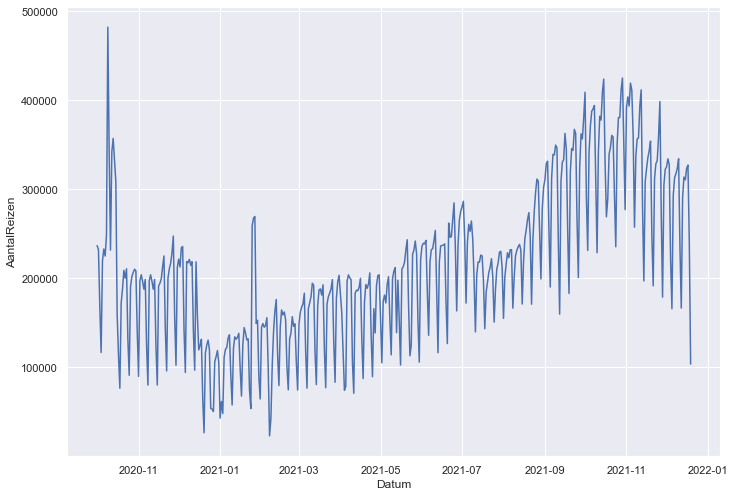

In [9]:
# travels per day in 2020-10 - 2020-12 period
gvb_data_range_very_cleaned_travellers_per_day = gvb_data_range_very_cleaned.groupby(['Datum']).sum().reset_index()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Datum", y="AantalReizen", data=gvb_data_range_very_cleaned_travellers_per_day);

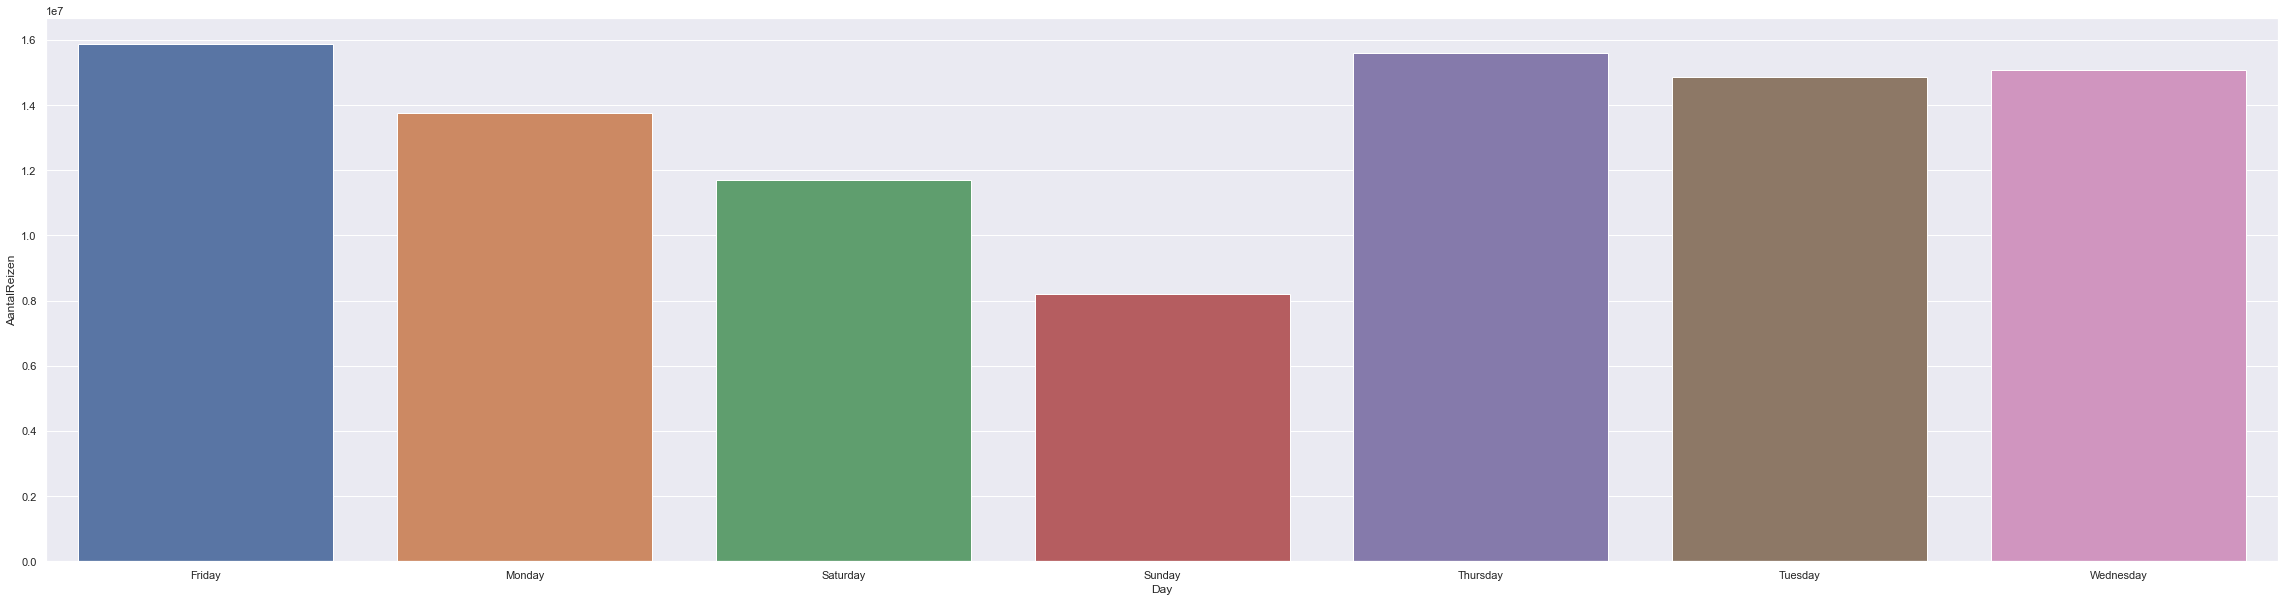

In [10]:
# Travels per day --> Sundays less public transport
gvb_data_range_very_cleaned_travellers_per_day['Day'] = gvb_data_range_very_cleaned_travellers_per_day[['Datum']].apply(lambda x: dt.datetime.strftime(x['Datum'], '%A'), axis=1)
range_summed_per_day = gvb_data_range_very_cleaned_travellers_per_day.groupby('Day').sum().reset_index()

plt.figure(figsize=(40,10))
sns.barplot(x="Day", y="AantalReizen", data=range_summed_per_day);


# Calculate stations near park

In [11]:
# Create DF with all stations with their lon and lat
stations_lon_lat = gvb_data_range_very_cleaned.drop_duplicates(subset=['AankomstHalteNaam'])[['AankomstHalteNaam', 'AankomstLat', 'AankomstLon']]
stations_lon_lat = stations_lon_lat.set_index('AankomstHalteNaam')
stations_lon_lat.rename(columns={"AankomstLat": "lat", "AankomstLon": "lng"}, inplace=True)
stations_lon_lat

,lat,lng
AankomstHalteNaam,,
Centraal Station,4.899218,52.378108
Station Diemen-Zuid,4.957133,52.330428
Station Lelylaan,4.834266,52.357663
Station Bijlmer ArenA,4.947135,52.311930
Bullewijk,4.952336,52.306422
...,...,...
Biesbosch,4.946083,52.330738
Durbanweg,4.734370,52.407657
Lorentzlaan,4.931976,52.345829


In [12]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def add_nearby_stations(radius, center_point_dict, add_to_list):
    """
    radius in km
    center_point_dict needs to be a dictionary with the lon and lat from a location
    add_to_list specify to which list this needs to be added (for example vondelpark)
    """
    latpark = center_point_dict[0]['lat']
    lonpark = center_point_dict[0]['lng']

    # check for every station if it is within 1 km distance of the park
    for station in range(len(stations_lon_lat)):
        name_station = stations_lon_lat.iloc[station].name
        latstation = stations_lon_lat.iloc[station].lat
        lonstation = stations_lon_lat.iloc[station].lng

        a = haversine(lonpark, latpark, lonstation, latstation)
        
        if a <= radius:
            add_to_list.append(name_station)

In [13]:
# Center points of all the parks (https://www.latlong.net/)
all_parks = ['vondelpark', 'oosterpark', 'sarphatipark',
               'westerpark', 'rembrandpark', 'erasmuspark']

vondelpark = [{'lat': 4.868648, 'lng': 52.357645}]
oosterpark = [{'lat': 4.920558, 'lng': 52.360098}]
sarphatipark = [{'lat': 4.896375, 'lng': 52.354364}]
westerpark = [{'lat': 4.873437, 'lng': 52.386986}]
rembrandpark = [{'lat': 4.846757, 'lng': 52.364145}]
erasmuspark = [{'lat': 4.851909, 'lng': 52.374808}]

# Create empty list that needs to be filled later
vondelpark_stations = []
oosterpark_stations = []
sarphatipark_stations = []
westerpark_stations = []
rembrandpark_stations = []
erasmuspark_stations = []

# calculate all station within 1 km from the park
add_nearby_stations(1,vondelpark,vondelpark_stations)
add_nearby_stations(1,oosterpark,oosterpark_stations)
add_nearby_stations(1,sarphatipark,sarphatipark_stations)
add_nearby_stations(1,westerpark,westerpark_stations)
add_nearby_stations(1,rembrandpark,rembrandpark_stations)
add_nearby_stations(1,erasmuspark,erasmuspark_stations)

In [14]:
# Example, stations near westerpark
westerpark_stations

['Van Hallstraat',
 'Fred. Hendrikplants.',
 'Assendelftstraat',
 'Spaarndammerstraat',
 'Van Beuningenplein',
 'Nassaukade',
 'De Wittenkade',
 'Van L.Stirumstraat',
 'V.d. Hoopstraat',
 'Kostverlorenstraat',
 'Nassauplein',
 'Haparandaweg',
 'Zaanstraat',
 'Archangelkade']

In [15]:
# day and time in one new column
gvb_data_range_travels = gvb_data_range_very_cleaned.copy()

gvb_data_range_travels['hour'] = gvb_data_range_travels['UurgroepOmschrijving (van aankomst)'].str[:5]
gvb_data_range_travels['hour'] = pd.to_datetime(gvb_data_range_travels['hour'], format='%H:%M').dt.time
gvb_data_range_travels['date'] = gvb_data_range_travels.apply(lambda r : pd.datetime.combine(r['Datum'],r['hour']),1)
gvb_data_range_travels = gvb_data_range_travels.set_index('date').reset_index()
gvb_data_range_travels = gvb_data_range_travels.drop(columns=['Datum', 'UurgroepOmschrijving (van aankomst)', 'AankomstHalteCode',
                                 'AankomstLat', 'AankomstLon', 'hour'])

gvb_data_range_travels


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,date,AankomstHalteNaam,AantalReizen
0,2020-10-01 00:00:00,Centraal Station,22
1,2020-10-01 16:00:00,Station Diemen-Zuid,139
2,2020-10-01 16:00:00,Centraal Station,1261
3,2020-10-01 16:00:00,Station Lelylaan,205
4,2020-10-01 16:00:00,Station Bijlmer ArenA,554
...,...,...,...
2138165,2021-12-19 13:00:00,Kattenburgerstraat,31
2138166,2021-12-19 13:00:00,Rietlandpark,14
2138167,2021-12-19 13:00:00,Rietlandpark,20
2138168,2021-12-19 13:00:00,Javaplein,14


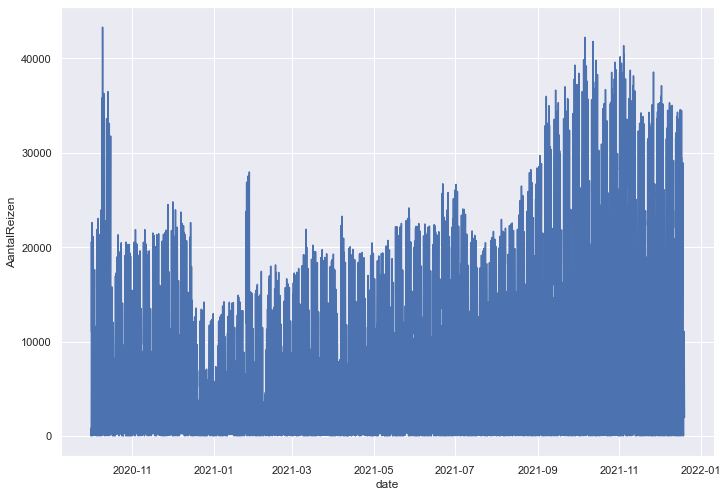

In [16]:
sns.lineplot(x="date", y="AantalReizen", data=gvb_data_range_travels.drop(columns=['AankomstHalteNaam']).groupby('date').sum());


In [212]:
vondelpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(vondelpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
oosterpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(oosterpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
sarphatipark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(sarphatipark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westerpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(westerpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
rembrandpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(rembrandpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
erasmuspark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(erasmuspark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()

# concatenate all dataframes into one, for later usage
vondelpark_journeys["park"] = "vondelpark"
oosterpark_journeys["park"] = "oosterpark"
sarphatipark_journeys["park"] = "sarphatipark"
westerpark_journeys["park"] = "westergasfabriek"
rembrandpark_journeys["park"] = "rembrandtpark"
erasmuspark_journeys["park"] = "erasmuspark"

frames = [vondelpark_journeys, oosterpark_journeys, sarphatipark_journeys,
          westerpark_journeys, rembrandpark_journeys, erasmuspark_journeys]
all_parks_journeys = pd.concat(frames)


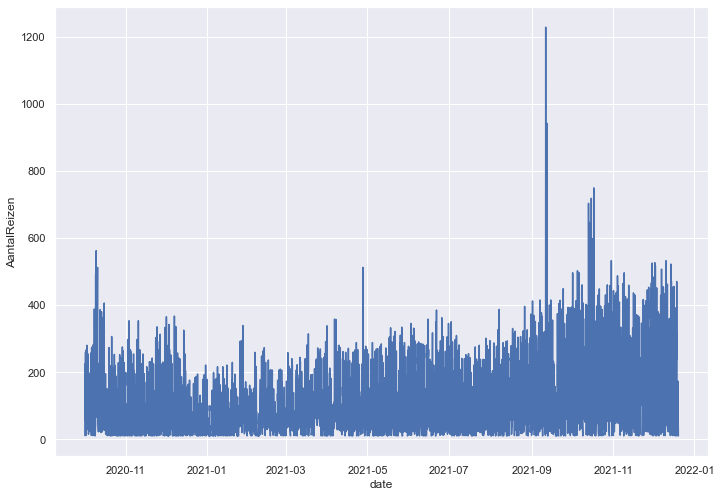

In [198]:
sns.lineplot(x="date", y="AantalReizen", data=westerpark_journeys.reset_index());

In [214]:
# Select Resono vondelpark data, make it (temporary) hourly to see the correlation with amount of journeys.
# Merge resono vondelpark data with gvb data. there are a lot of values that can not be matched, during the
# night trams do not run.

# create list of unique locations and empty list with potential resono x park lists
locations = resono["Location"].unique().tolist()
resono_park_list = []

for location in locations:
    print(location)
    # create dynamic name (https://www.delftstack.com/howto/python/python-dynamic-variable-name/)
    name = f"resono_{location.lower()}"
    name = "_".join(name.split())
    resono_park_list.append(name)
    
    # prepare resono data
    resono_park = resono[resono['Location'] == location]
    resono_park = resono_park.set_index('Start')
    resono_park.index = pd.to_datetime(resono_park.index, utc=True)
    df_resono_park_hourly = resono_park.resample('H').sum().drop(columns = ['Unnamed: 0'])
    df_resono_park_hourly.index = df_resono_park_hourly.index.tz_convert(None)
    df_resono_park_hourly.index = df_resono_park_hourly.index.tz_localize('utc') 
    
    # prepare gvb data of certain park 
    gvb_park = all_parks_journeys[all_parks_journeys["park"] == location.split().pop(0).lower()]
    gvb_park.index = gvb_park.index.tz_localize('utc')
    
    # merge gvb and resono to new dynamic df
    globals()[name] = df_resono_park_hourly.loc["2020-10":].join(gvb_park) 
    globals()[name].index = globals()[name].index.tz_convert(None)

Sarphatipark
Rembrandtpark Noord
Rembrandtpark Zuid
Vondelpark Oost
Vondelpark West
Oosterpark
Westergasfabriek
Erasmuspark


In [215]:
resono_park_list

['resono_sarphatipark',
 'resono_rembrandtpark_noord',
 'resono_rembrandtpark_zuid',
 'resono_vondelpark_oost',
 'resono_vondelpark_west',
 'resono_oosterpark',
 'resono_westergasfabriek',
 'resono_erasmuspark']

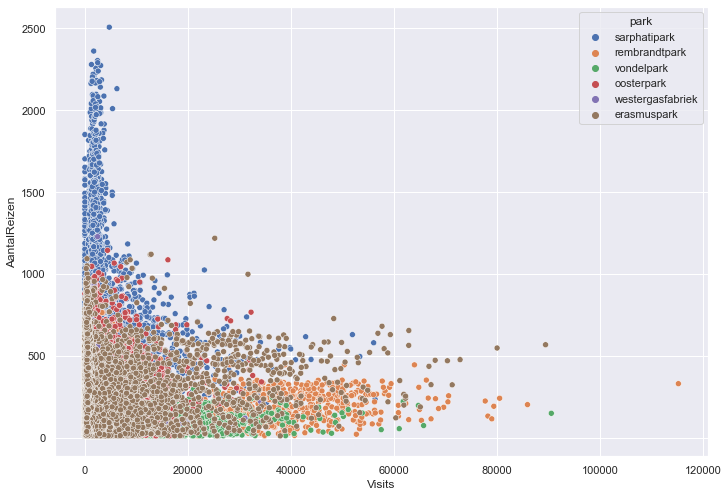

In [239]:
frames = [resono_sarphatipark, resono_rembrandtpark_noord, resono_rembrandtpark_zuid,
         resono_vondelpark_oost, resono_vondelpark_west, resono_oosterpark,
         resono_westergasfabriek, resono_erasmuspark]

all_resono_park = pd.concat(frames)

sns.scatterplot(data=all_resono_park, x="Visits", y="AantalReizen", hue="park");

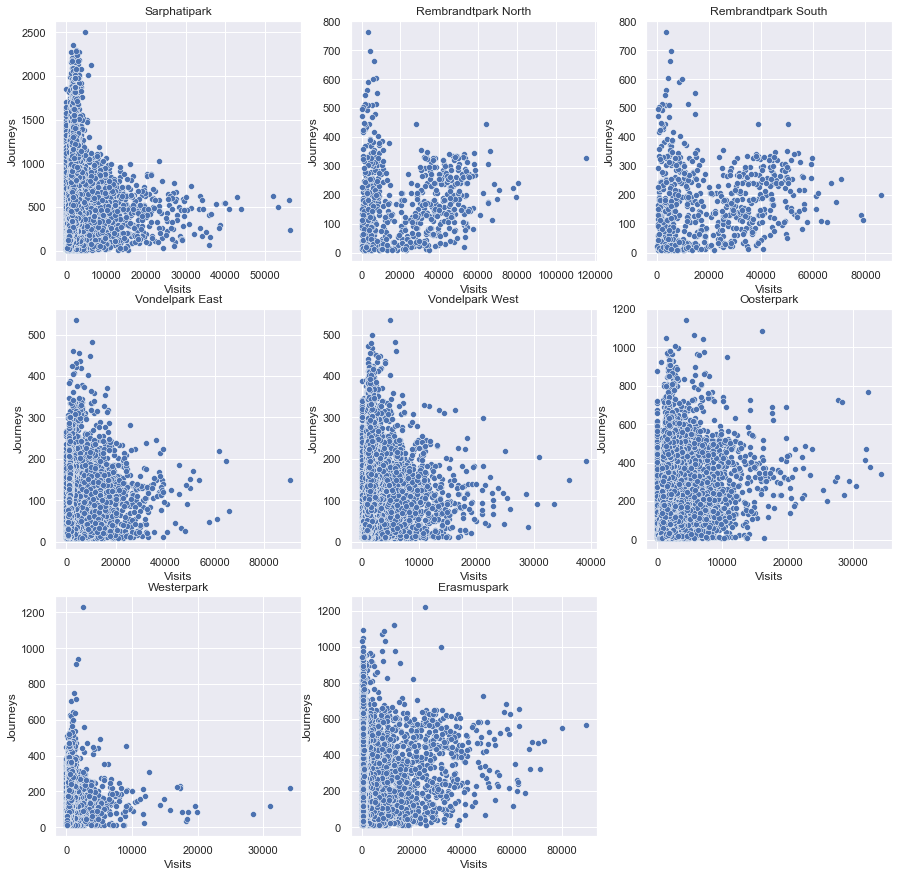

In [266]:
frames = [resono_sarphatipark, resono_rembrandtpark_noord, resono_rembrandtpark_zuid,
         resono_vondelpark_oost, resono_vondelpark_west, resono_oosterpark,
         resono_westergasfabriek, resono_erasmuspark]

f, axes = plt.subplots(3, 3, figsize=(15, 15))

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_sarphatipark, ax=axes[0][0])
axes[0][0].set_title("Sarphatipark")
axes[0][0].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_rembrandtpark_noord, ax=axes[0][1])
axes[0][1].set_title("Rembrandtpark North")
axes[0][1].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_rembrandtpark_zuid, ax=axes[0][2])
axes[0][2].set_title("Rembrandtpark South")
axes[0][2].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_vondelpark_oost, ax=axes[1][0])
axes[1][0].set_title("Vondelpark East")
axes[1][0].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_vondelpark_west, ax=axes[1][1])
axes[1][1].set_title("Vondelpark West")
axes[1][1].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_oosterpark, ax=axes[1][2])
axes[1][2].set_title("Oosterpark")
axes[1][2].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_westergasfabriek, ax=axes[2][0])
axes[2][0].set_title("Westerpark")
axes[2][0].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_erasmuspark, ax=axes[2][1])
axes[2][1].set_title("Erasmuspark")
axes[2][1].set_ylabel("Journeys")

axes[2,2].set_axis_off()

In [291]:
# Make all GVB data 15 min
vondelpark_journeys_15min = vondelpark_journeys.resample('15T').pad()
vondelpark_journeys_15min['AantalReizen'] = vondelpark_journeys_15min['AantalReizen'] / 4

oosterpark_journeys_15min = oosterpark_journeys.resample('15T').pad()
oosterpark_journeys_15min['AantalReizen'] = oosterpark_journeys_15min['AantalReizen'] / 4

sarphatipark_journeys_15min = sarphatipark_journeys.resample('15T').pad()
sarphatipark_journeys_15min['AantalReizen'] = sarphatipark_journeys_15min['AantalReizen'] / 4

westerpark_journeys_15min = westerpark_journeys.resample('15T').pad()
westerpark_journeys_15min['AantalReizen'] = westerpark_journeys_15min['AantalReizen'] / 4

rembrandpark_journeys_15min = rembrandpark_journeys.resample('15T').pad()
rembrandpark_journeys_15min['AantalReizen'] = rembrandpark_journeys_15min['AantalReizen'] / 4

erasmuspark_journeys_15min = erasmuspark_journeys.resample('15T').pad()
erasmuspark_journeys_15min['AantalReizen'] = erasmuspark_journeys_15min['AantalReizen'] / 4

In [304]:
# Select Resono vondelpark data
# Make GVB data 15 minutes

# create list of unique locations and empty list with potential resono x park lists
locations = resono["Location"].unique().tolist()
resono_park_list_15min = []

for location in locations:
    print(location)
    # create dynamic name (https://www.delftstack.com/howto/python/python-dynamic-variable-name/)
    name = f"min15_resono_{location.lower()}"
    name = "_".join(name.split())
    resono_park_list_15min.append(name)
    
    # prepare resono data
    resono_park = resono[resono['Location'] == location]
    resono_park = resono_park.set_index('Start')
    resono_park.index = pd.to_datetime(resono_park.index, utc=True)
    resono_park.index = resono_park.index.tz_convert(None)
    resono_park.index = resono_park.index.tz_localize('utc') 
    
    # prepare gvb data of certain park 
    gvb_park = all_parks_journeys[all_parks_journeys["park"] == location.split().pop(0).lower()]
    gvb_park.index = gvb_park.index.tz_localize('utc')

    # merge gvb and resono to new dynamic df
    globals()[name] = resono_park.loc["2020-10":].join(gvb_park) 
    globals()[name].index = globals()[name].index.tz_convert(None)

Sarphatipark
Rembrandtpark Noord
Rembrandtpark Zuid
Vondelpark Oost
Vondelpark West
Oosterpark
Westergasfabriek
Erasmuspark


In [305]:
resono_park_list_15min

['min15_resono_sarphatipark',
 'min15_resono_rembrandtpark_noord',
 'min15_resono_rembrandtpark_zuid',
 'min15_resono_vondelpark_oost',
 'min15_resono_vondelpark_west',
 'min15_resono_oosterpark',
 'min15_resono_westergasfabriek',
 'min15_resono_erasmuspark']

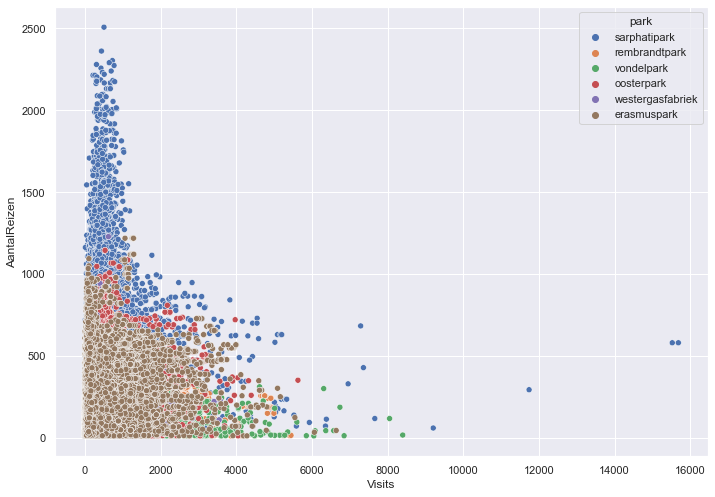

In [307]:
frames = [min15_resono_sarphatipark, min15_resono_rembrandtpark_noord, min15_resono_rembrandtpark_zuid,
         min15_resono_vondelpark_oost, min15_resono_vondelpark_west, min15_resono_oosterpark,
         min15_resono_westergasfabriek, min15_resono_erasmuspark]

min15_all_resono_park = pd.concat(frames)

sns.scatterplot(data=min15_all_resono_park, x="Visits", y="AantalReizen", hue="park");

In [ ]:
# CODE CAN BE REMOVED EVENTUALLY
resono_oosterpark = resono[resono['Location'] == 'Oosterpark']
resono_oosterpark['Start'] = pd.to_datetime(resono_oosterpark['Start'], utc=True)
resono_oosterpark = resono_oosterpark.set_index('Start')

resono_oosterpark_hourly = resono_oosterpark.resample('H').sum().drop(columns = ['Unnamed: 0'])
resono_oosterpark_hourly.index = resono_oosterpark_hourly.index.tz_convert(None)

resonoXvisits_oosterpark = resono_oosterpark_hourly.loc["2020-10":].join(vondelpark_journeys)
resonoXvisits_oosterpark = resonoXvisits_oosterpark.dropna()
resonoXvisits_oosterpark

sns.scatterplot(data=resonoXvisits_oosterpark, x="Visits", y="AantalReizen");